In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from random import shuffle
from sklearn.model_selection import ShuffleSplit
import math
from sklearn.metrics import mean_squared_error

#### Import raw data and background knowledge 

In [ ]:
def isnull_df(df):
    print(df.isnull().sum())
def read_csv(file,delimiter=",", parse_dates=True):
    df = pd.read_csv(file, delimiter=",", parse_dates=True)
    return df

In [2]:
station_data = pd.read_csv("station_data.csv", delimiter=",", parse_dates=True)
trip_data = pd.read_csv("trip_data.csv", delimiter=",", parse_dates=True)
weather_data = pd.read_csv("weather_data.csv", delimiter=",", parse_dates=True)

In [3]:
moved_station_list = [23,85,25,86,49,87,69,88,72,89,90]
moved_station_pair = [[23,85],[25,86],[49,87],[69,88],[72,89],[89,90]]

#### Check invalid/NaN data and also the moved stations information  

In [4]:
# replace the moved station with new IDs 
trip_data_ETL = trip_data
for before,after in moved_station_pair:
    trip_data_ETL['Start Station'] = trip_data_ETL['Start Station'].replace(before,after)
    trip_data_ETL['End Station'] = trip_data_ETL['End Station'].replace(before,after)

# convert the time into datetime type 
trip_data_ETL['Start Date'] = trip_data_ETL['Start Date'].apply(pd.to_datetime)
trip_data_ETL['End Date'] = trip_data_ETL['End Date'].apply(pd.to_datetime)

In [7]:
station_data_ETL = station_data
for before,after in moved_station_pair:
    station_data_ETL['Id'] = station_data_ETL['Id'].replace(before,after)
station_data_ETL = station_data.drop_duplicates(subset=['Id'], keep='last')

In [8]:
trip_data_ETL.to_pickle('ETL.pkl')
# trip_data_ETL = pd.read_pickle('ETL.pkl')
station_data_ETL.to_pickle('stationETL.pkl')

In [9]:
Ids = station_data_ETL['Id'].values
dockN = station_data_ETL['Dock Count'].values
station_dock = {}
for id , dock in zip(Ids,dockN):
    station_dock[id] = dock

#### Identify the weather influence for renting the bike 
for example it is too windy that day
* return the bad weather \[date ,zip , weather condition which is not good for riding]

#### TODO concat those date and zip code for detecting the abnormal trip_data due to the weather 
 if the date match , the data could be outliers 

#### Feature Engineering ON trip_data.csv ['Trip ID', 'Start Date', 'Start Station', 'End Date', 'End Station', 'Subscriber Type'] 

* 'Subscriber Type': "Subscriber" weight should be bigger than "Customer" as regularly user
* 'Trip ID' is reused for unknown pattern, for pair of "rent" | "return" 
    - eg. trip_data_ETL[trip_data_ETL['Trip ID']==913460]
    
* 'Start Date' and 'End Date' could saved into bins(interval as hour)

##### Connection among data set 
* Location relation : trip_data.%Station  <---- > station_data.City <---> weather_data.Zip
* Time seriel relation : trip_data.%Date <---> weather_data.Date

### convert  raw data : records  -- > target data: matrix 
matrix [id,timestamp] = -1*records[start,timestamp] + 1* records[end,timestamp]

In [100]:
# predict training set is based on "one day" dataset
def cross_check_error(df):
    df['date'] = df.index.date
    list_date = sorted(set(df.index.date))
    shuffle(list_date)
    size=len(list_date)
    train_index =math.ceil(size*0.7)
    clf = LinearRegression()
#     clf = SVR(kernel='rbf', C=1e3, gamma=0.1)
#     clf = SVR(kernel='linear', C=1e3)
#     clf = SVR(kernel='poly', C=1e3, degree=1)
    
    # train model per day
    for i in list_date[0:train_index] :
        daily_df = df[df['date'].isin([i])]
        X = daily_df.index.values.reshape(-1,1).astype('float64', casting='unsafe')
        Y = daily_df['value'].values.reshape(-1,1)
        clf.fit(X,Y)

    # validate the model with validate set , count error
    error = 0
    for i in list_date[train_index:-1]:
        daily_df = df[df['date'].isin([i])]
        X = daily_df.index.values.reshape(-1,1).astype('float64', casting='unsafe')
        Y = daily_df['value'].values.reshape(-1,1)
        Y_pred = clf.predict(X)
        error +=mean_squared_error(Y, Y_pred)
    df.plot()
    return error,clf

id 2 	 error 252.333333
id 3 	 error 25.033333
id 4 	 error 751918.655252
id 5 	 error 3355589.742424
id 6 	 error 50.666667
id 7 	 error 25.266667
id 8 	 error 16.375000
id 9 	 error 14535.127171
id 10 	 error 1869.887313
id 11 	 error 29.208333


/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


id 12 	 error 13.851190
id 13 	 error 38208.911736
id 14 	 error 126509.812577
id 16 	 error 15.983333
id 21 	 error 1081967.729371
id 22 	 error 25.975490
id 85 	 error 3.666667
id 24 	 error 1.875000
id 86 	 error 13.183824
id 26 	 error 5.199561
id 27 	 error 28532.422101
id 28 	 error 150.750000
id 29 	 error 705010.120618
id 30 	 error 593601.574581
id 31 	 error 26.291667
id 32 	 error 39.450000
id 33 	 error 12.250000
id 34 	 error 28.903846
id 35 	 error 3093.928013
id 36 	 error 168559.646593
id 37 	 error 94293.530495
id 38 	 error 8.833333
id 41 	 error 230.533333
id 42 	 error 86265.565748
id 45 	 error 279.208333
id 46 	 error 1335602.732824
id 47 	 error 1305949.450392
id 48 	 error 21661207.531552
id 87 	 error 165.833333
id 50 	 error 310948218.705948
id 51 	 error 489.024510
id 39 	 error 4261055.548761
id 54 	 error 291.916667
id 55 	 error 39686248.153556
id 56 	 error 220.750988
id 57 	 error 228.958333
id 58 	 error 55.882051
id 59 	 error 1663356.014774
id 60 	 er

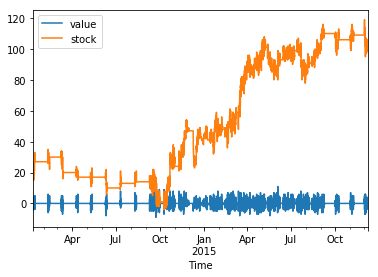

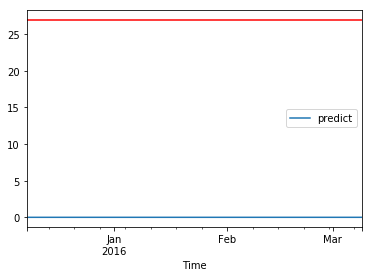

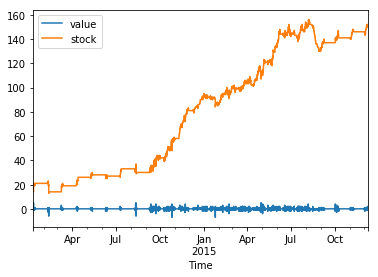

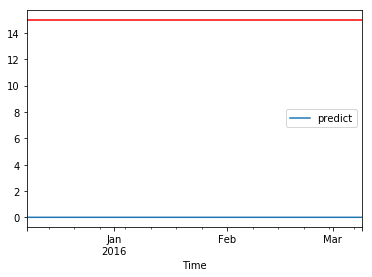

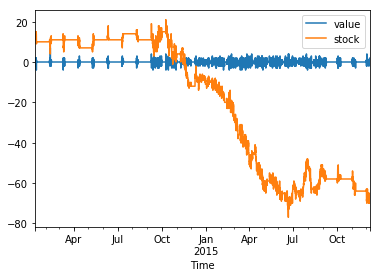

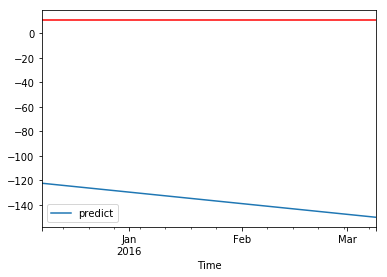

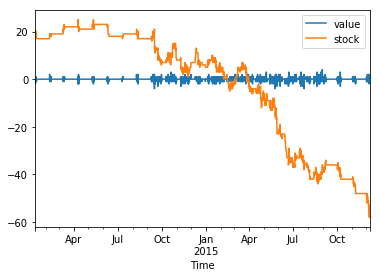

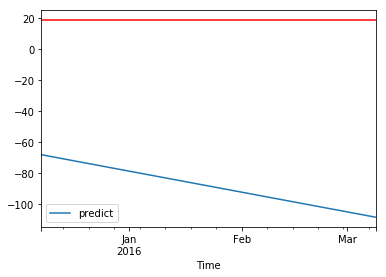

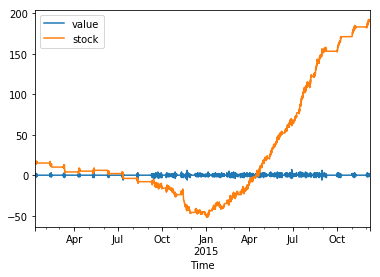

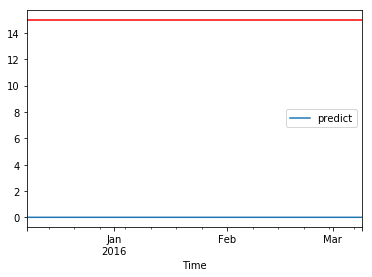

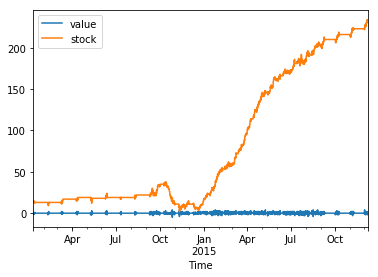

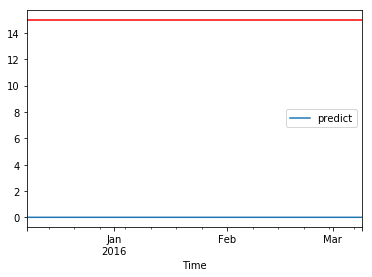

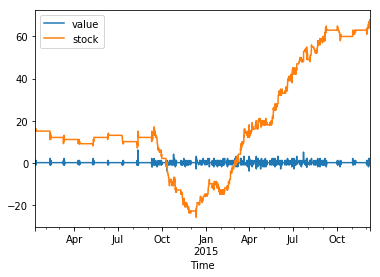

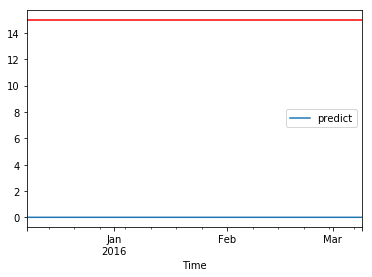

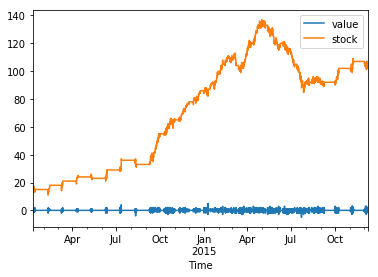

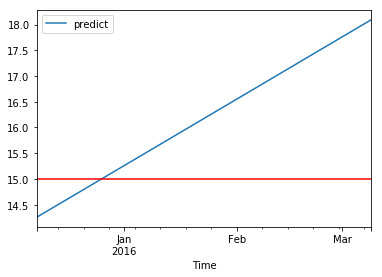

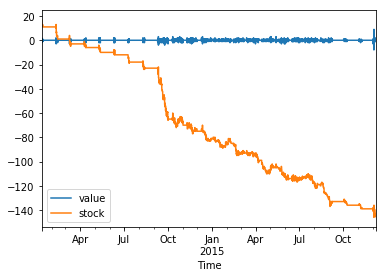

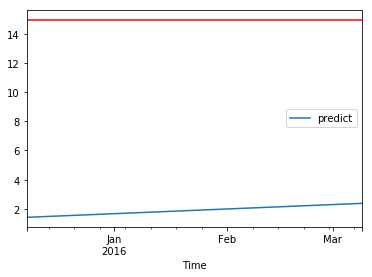

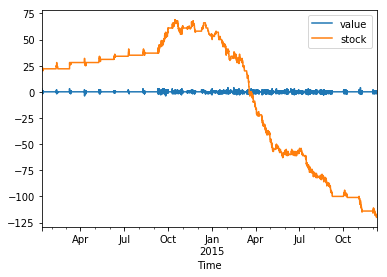

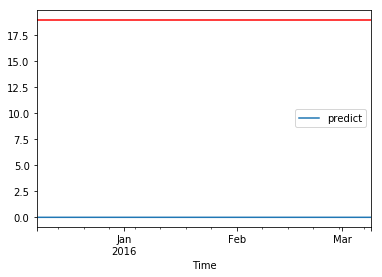

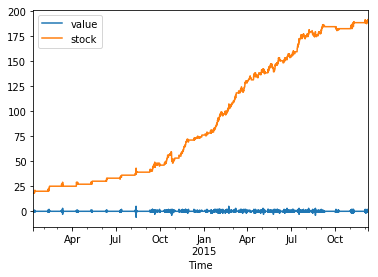

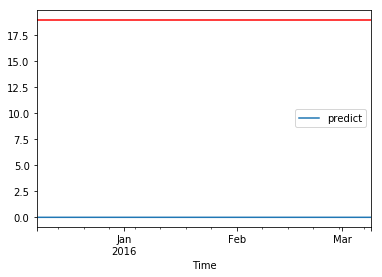

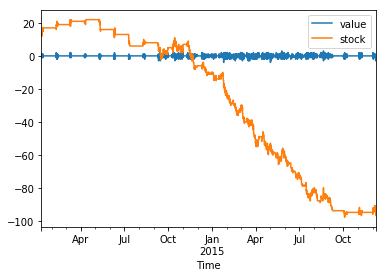

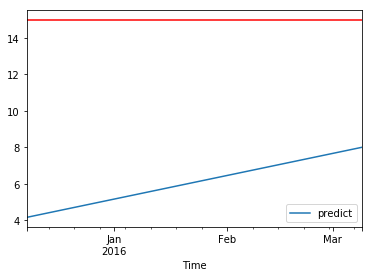

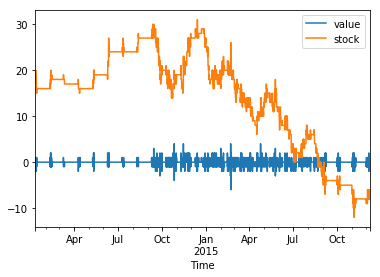

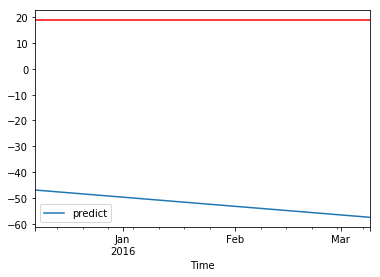

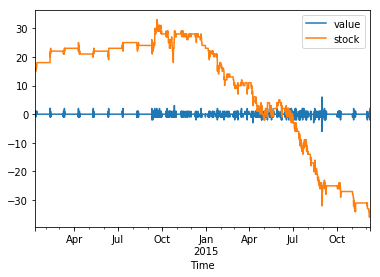

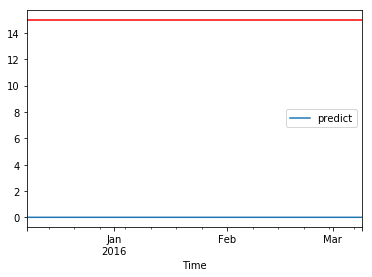

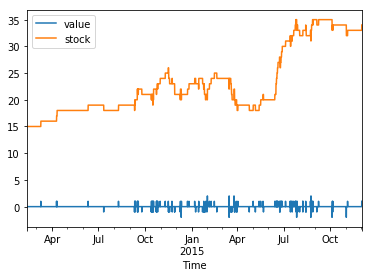

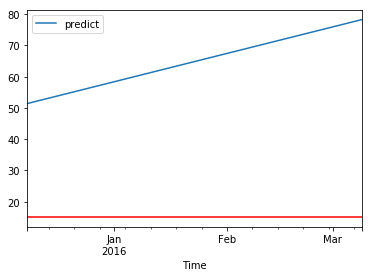

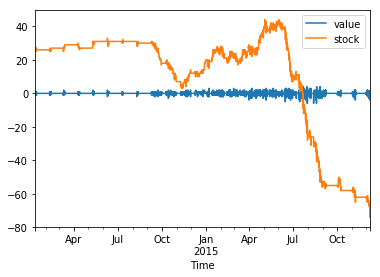

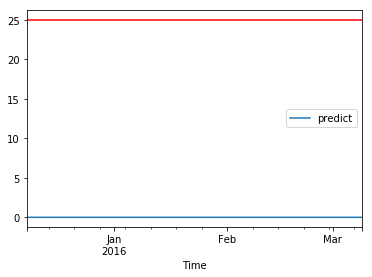

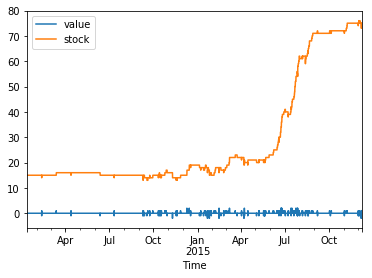

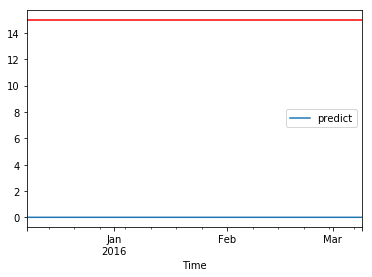

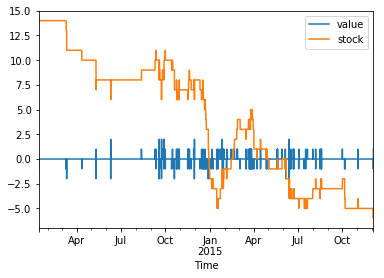

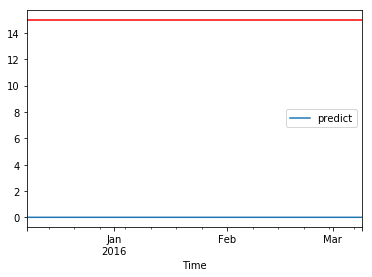

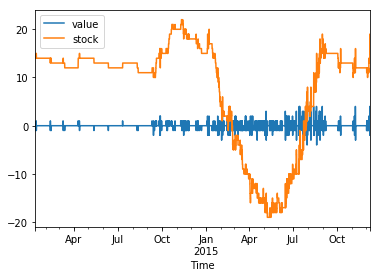

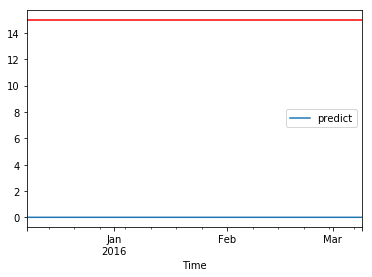

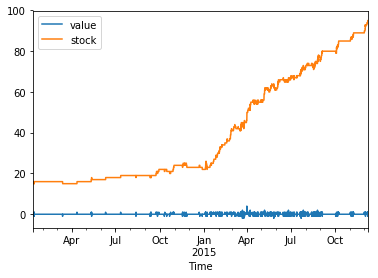

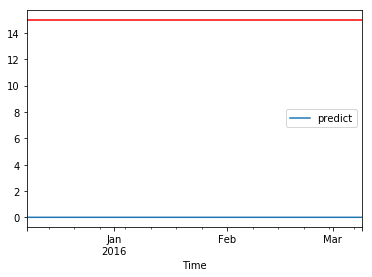

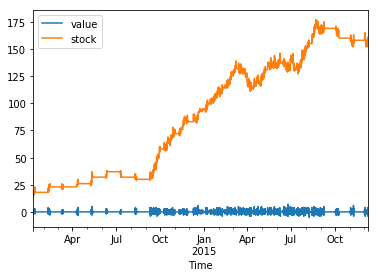

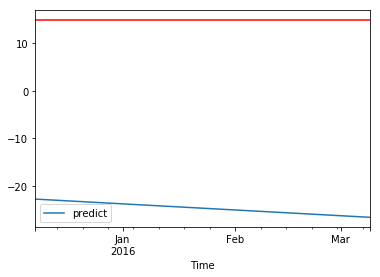

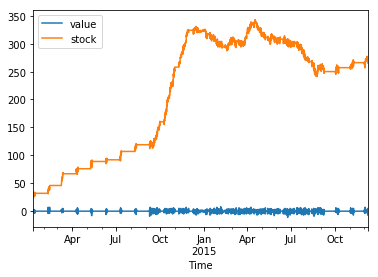

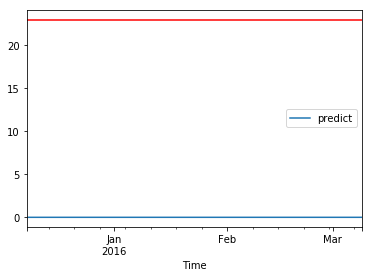

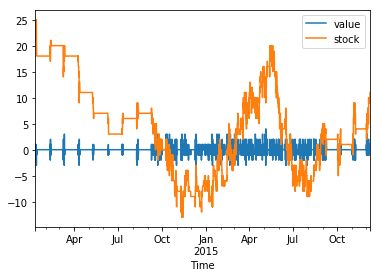

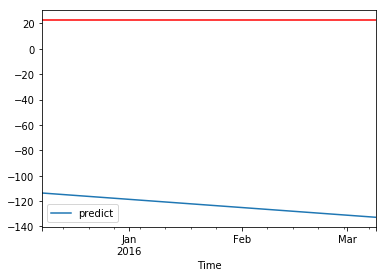

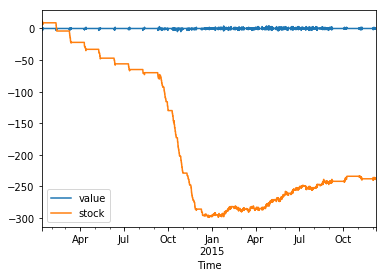

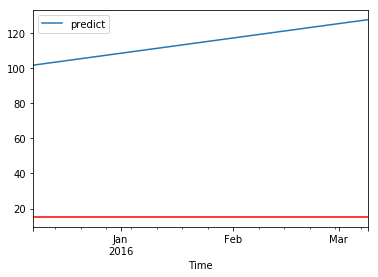

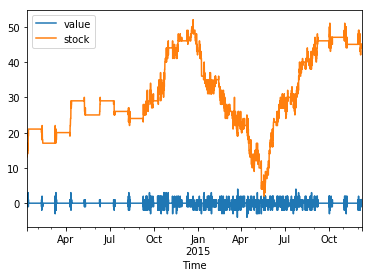

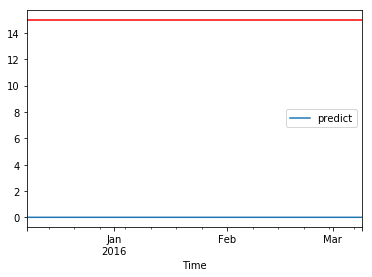

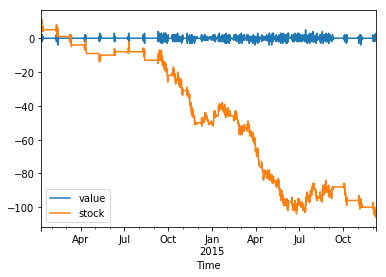

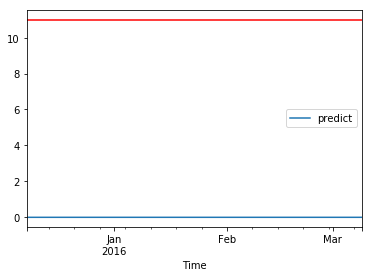

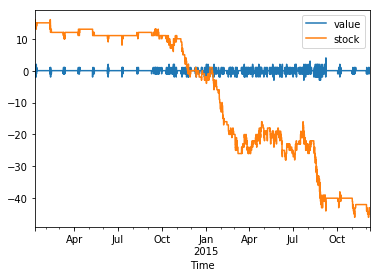

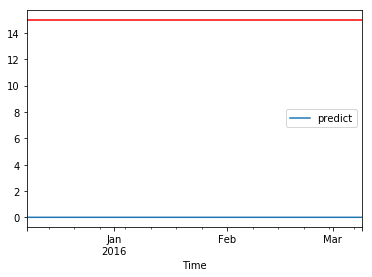

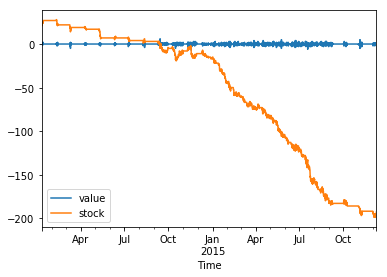

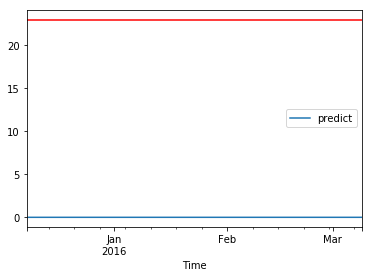

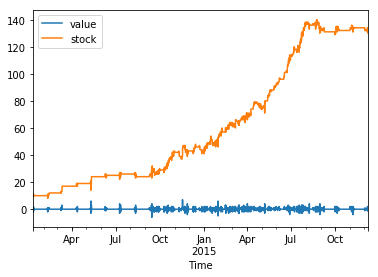

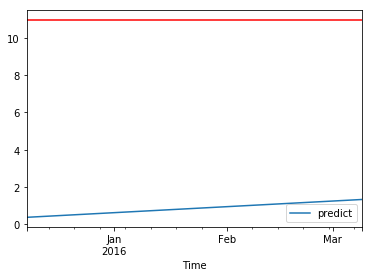

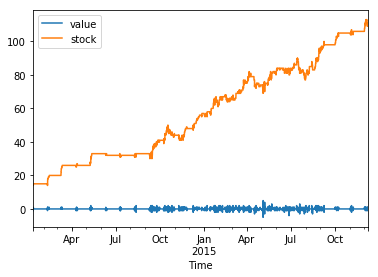

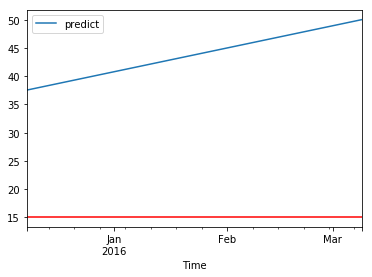

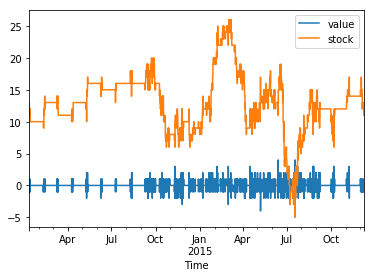

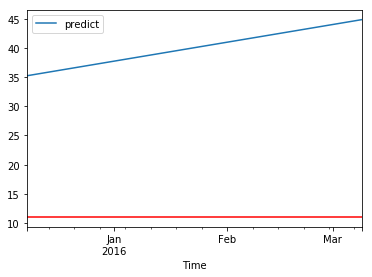

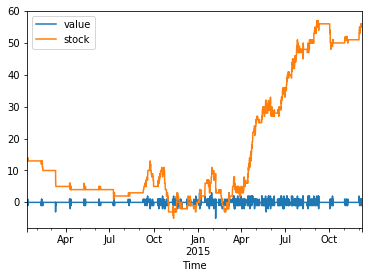

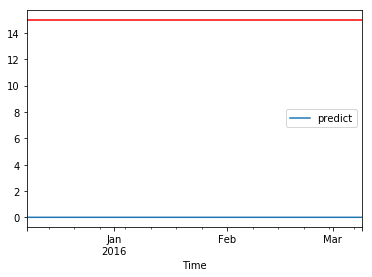

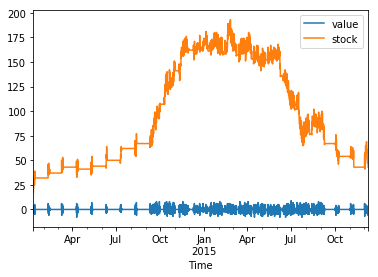

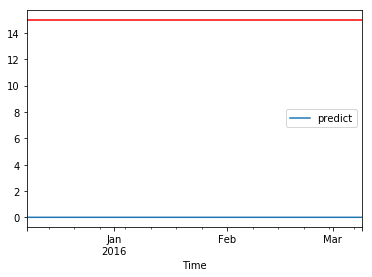

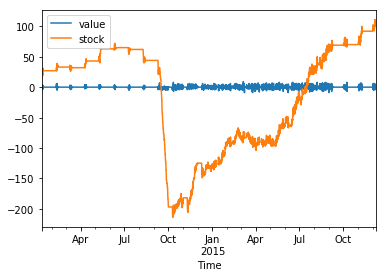

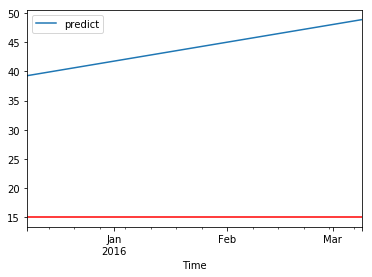

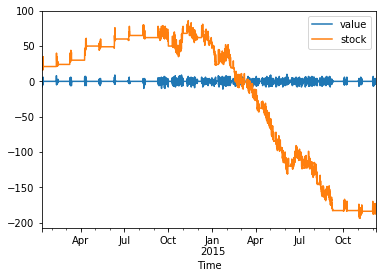

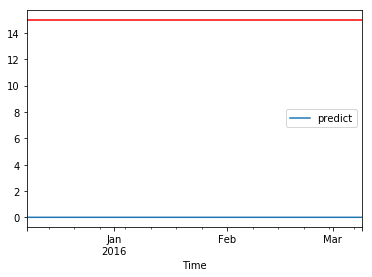

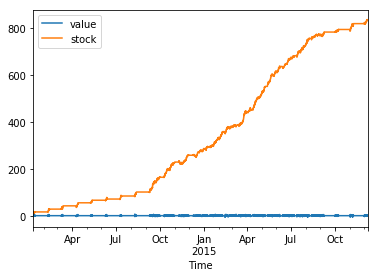

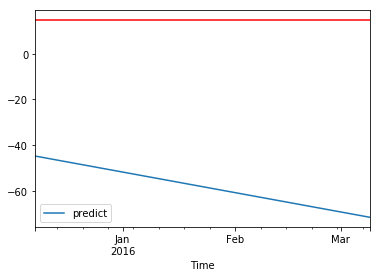

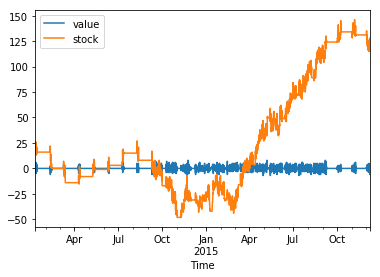

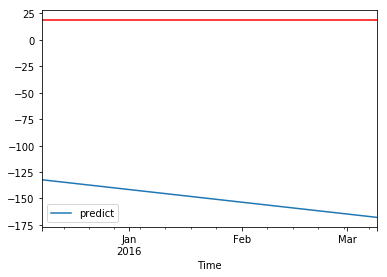

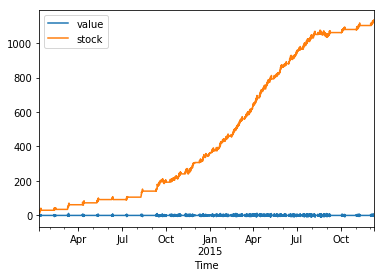

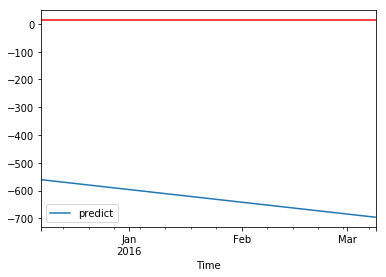

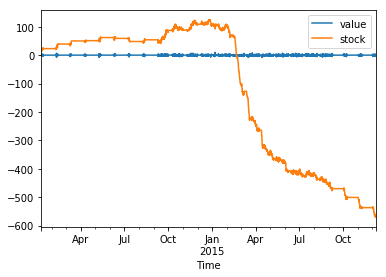

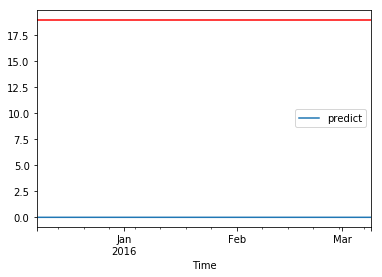

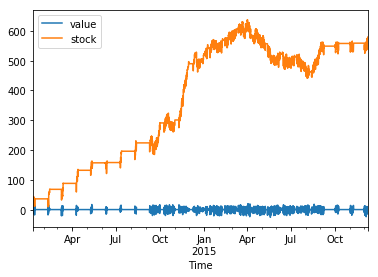

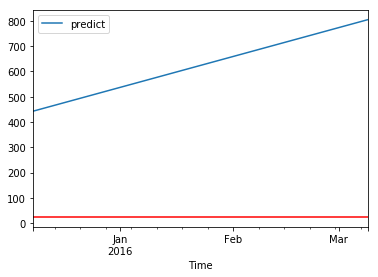

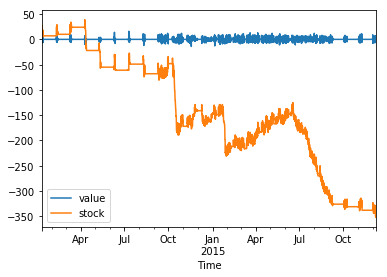

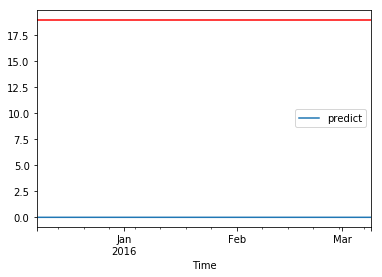

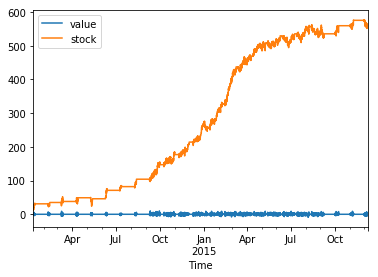

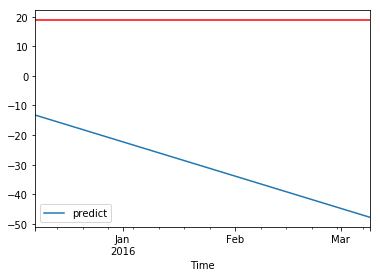

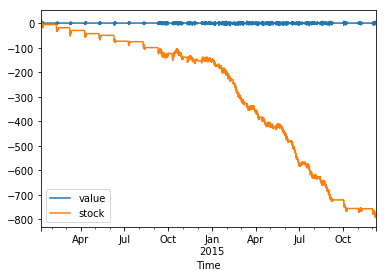

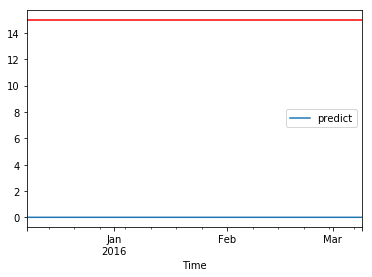

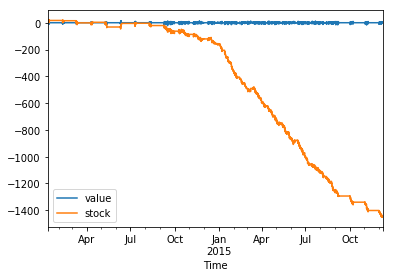

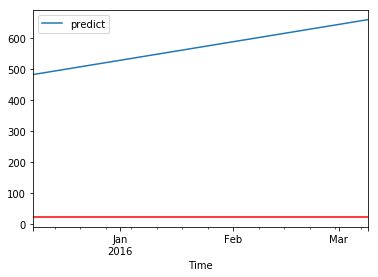

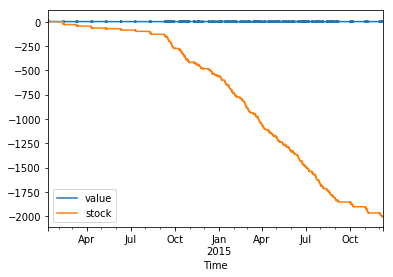

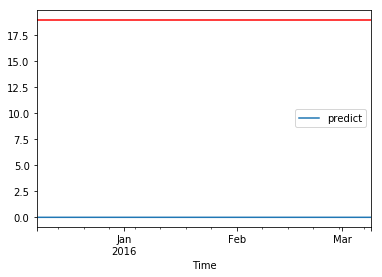

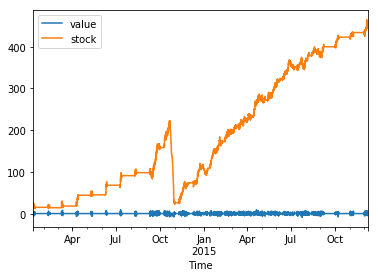

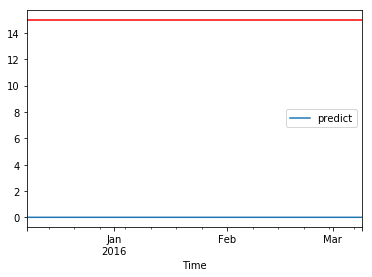

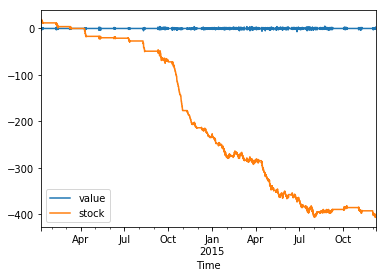

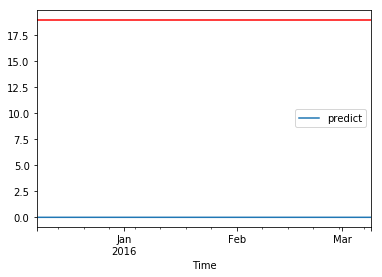

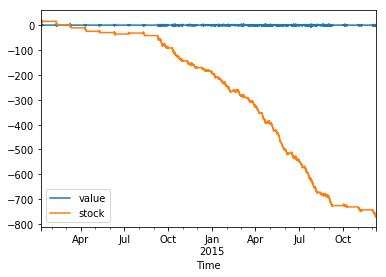

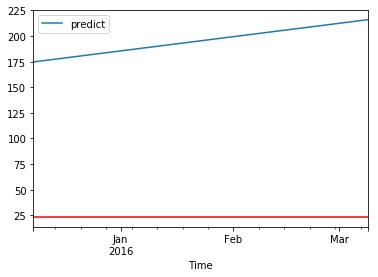

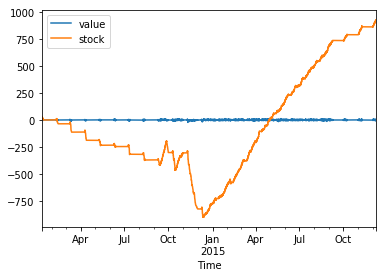

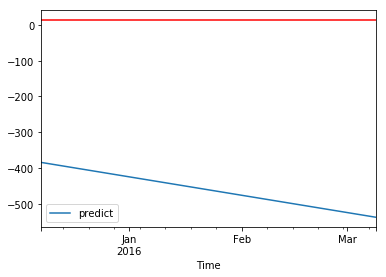

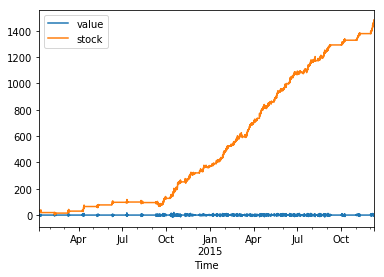

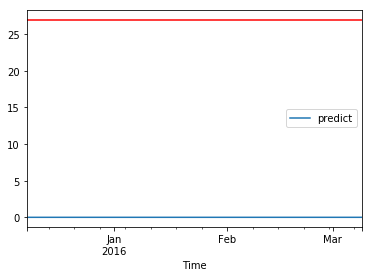

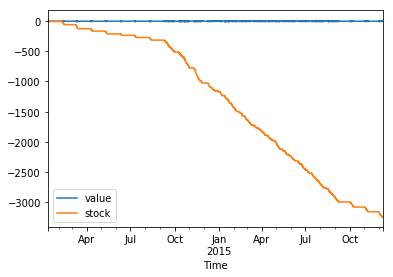

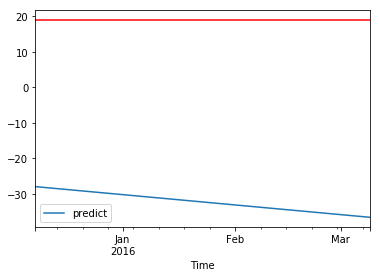

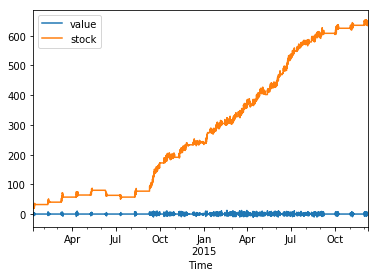

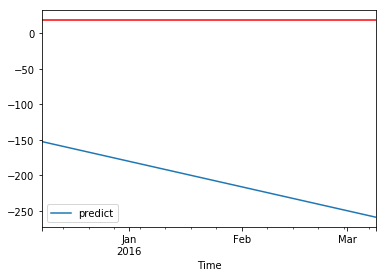

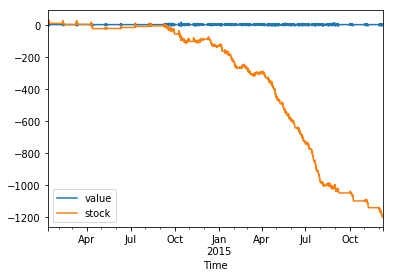

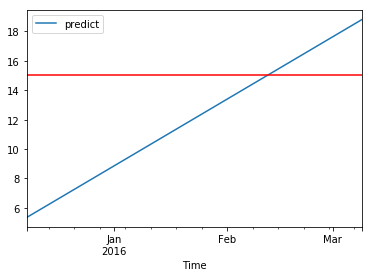

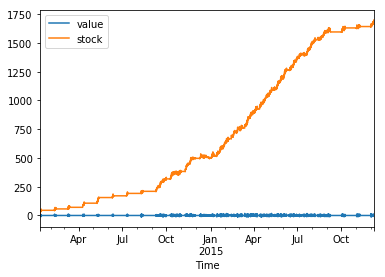

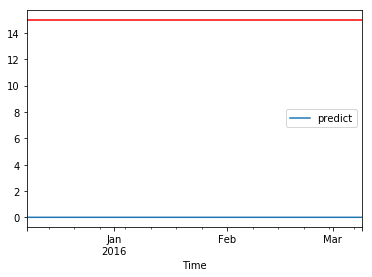

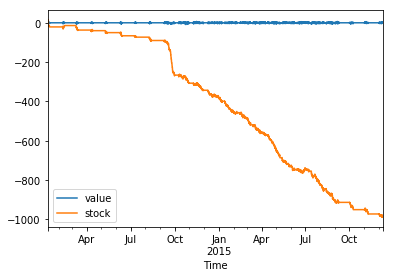

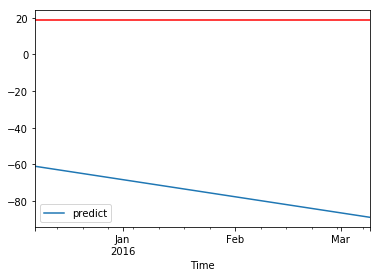

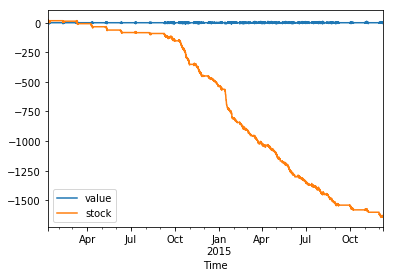

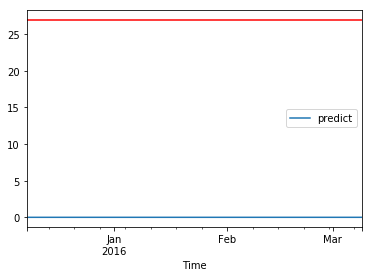

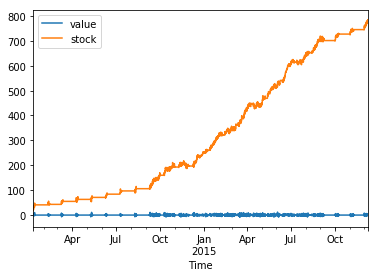

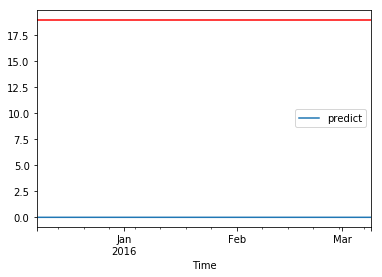

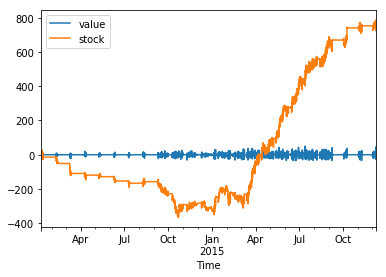

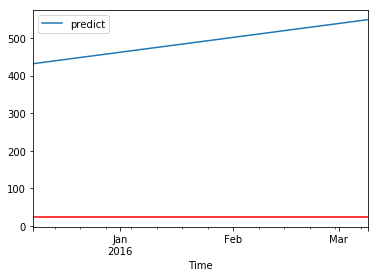

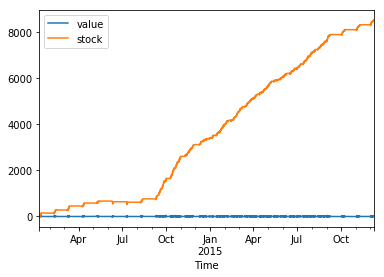

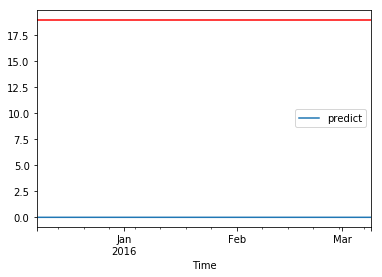

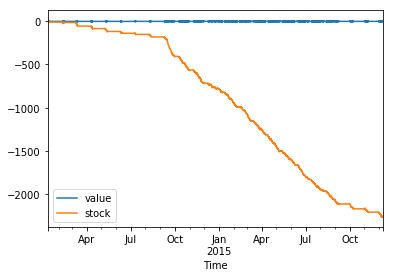

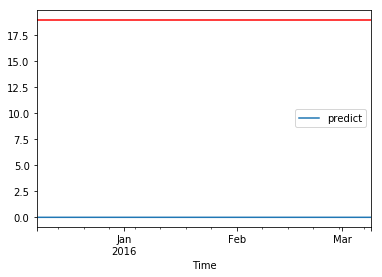

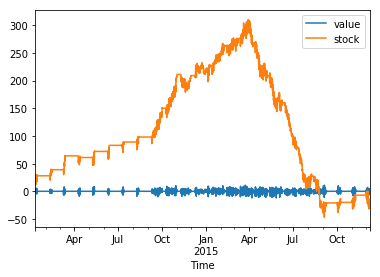

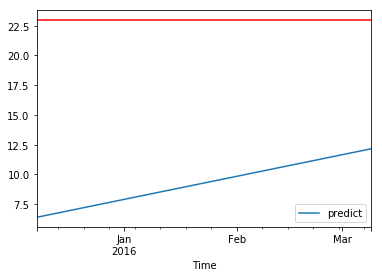

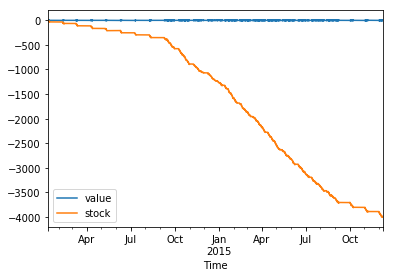

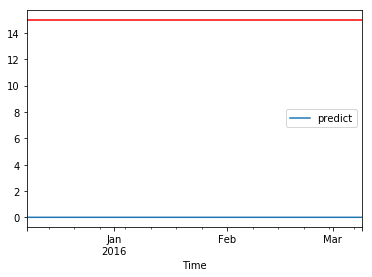

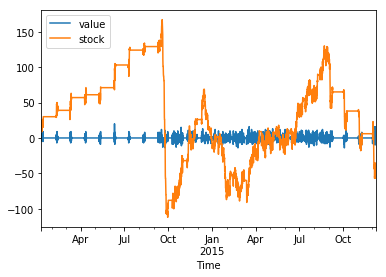

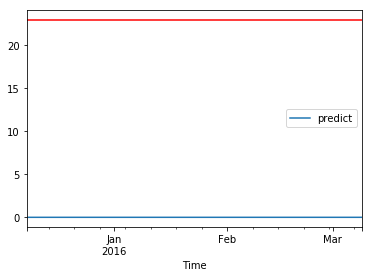

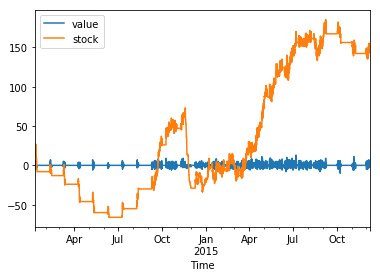

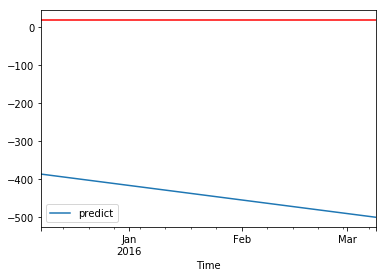

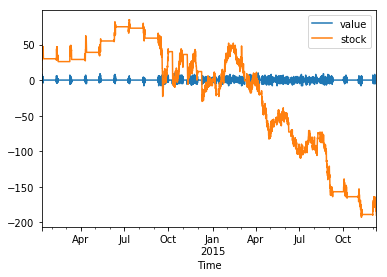

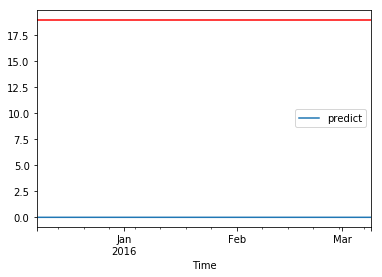

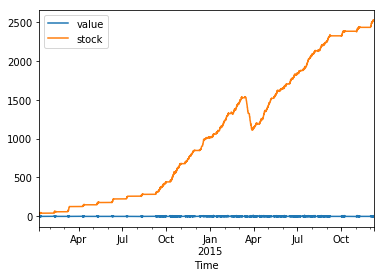

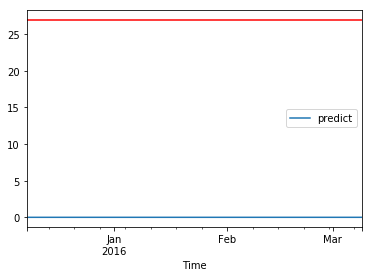

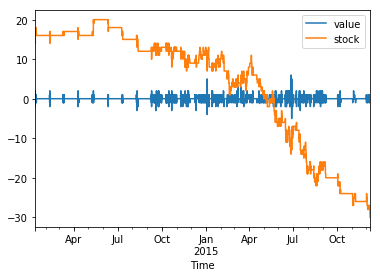

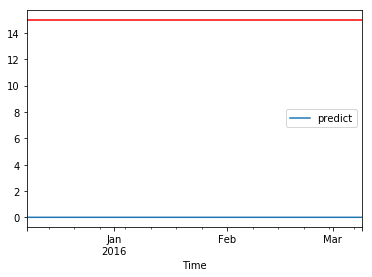

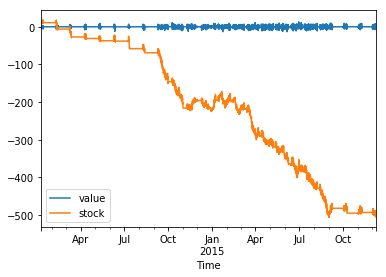

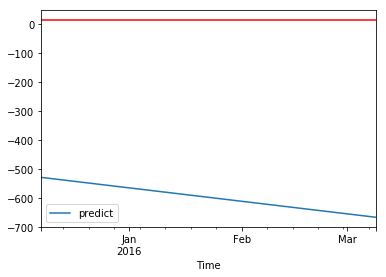

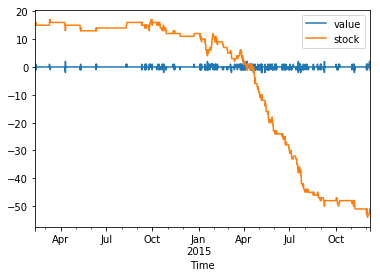

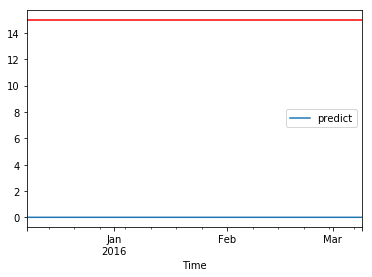

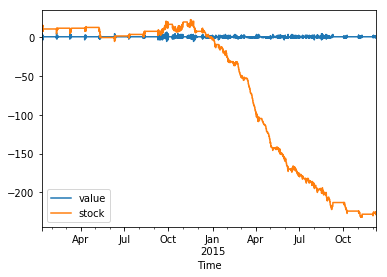

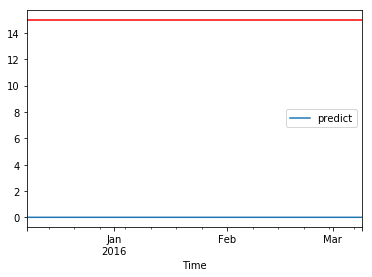

In [101]:
for id in Ids:
    # create change df on timeline
    minus = trip_data.loc[trip_data['Start Station'] == id]['Start Date']
    plus = trip_data.loc[trip_data['End Station'] == id]['End Date']
    df_i_minus = pd.DataFrame()
    df_i_minus['Time'] = minus.values
    df_i_minus['value']= [-1]*minus.shape[0]

    df_i_plus = pd.DataFrame()
    df_i_plus['Time'] = plus.values
    df_i_plus['value']= [1]*plus.shape[0]

    df_i = pd.concat([df_i_minus, df_i_plus])
    df_i = df_i.set_index('Time')
    df_i = df_i.sort_index()
    df = df_i.groupby(pd.TimeGrouper(freq='H')).sum().fillna(0)
    
    # create "how many bikes left " df on timeline
    dock_left = [station_dock[id]]
    for index,value in list(enumerate(df['value'].values, start=0)):
        dock_left.append(dock_left[index]+value)
    df['stock'] = dock_left[1:]
    
    # training model  
    error,clf = cross_check_error(df)
    print("id",id,"\t","error",'{:f}'.format(error))

    # predict future
    df_predict = pd.DataFrame()
    df_predict['Time']=pd.date_range("2015-12-08 00:00", 
                          "2016-03-09  00:00", 
                          freq="60min")
    df_predict = df_predict.set_index('Time')
    df_predict = df_predict.groupby(pd.TimeGrouper(freq='H')).sum().fillna(0)
    new_X = df_predict.index.values.reshape(-1,1).astype('float64', casting='unsafe')
    
    y_pred= clf.predict(new_X)
    df_predict['predict']= y_pred
    df_predict.plot()
    plt.axhline(y=station_dock[id], color='r', linestyle='-')